# Preamble

In [1]:
CODE_PATH = r'C:/Git/HonoursProject/ipw-clusterer/ipw_clusterer/'
DATA_PATH = r'C:/Git/HonoursProject/ipw-clusterer/data/'

EDA = False #Show Exploratory Data Analyis
SHOW_MODEL_PLOTS = True #Show model plots

In [2]:
# add source python files to project
import sys
sys.path.insert(0, CODE_PATH) 
import ipw

In [3]:
#import io
import logging
import numpy as np
import pandas as pd
#import re
#import math

In [4]:
logging.basicConfig(filename = 'log.txt', level = logging.DEBUG, format='%(asctime)s %(levelname)s %(message)s')

# Load the data

In [5]:
df = ipw.parse.read(DATA_PATH)

## Nr of records

In [6]:
if EDA:
    print(f'Total records: {len(df)}')
    print('Records per status:')
    print(df['status'].value_counts(dropna = False))

In [7]:
# Select closed records
df = df[df['status'] == 'closed']
df.drop('status', axis = 1, inplace = True)

## Clean the text fields

In [8]:
df = ipw.parse.clean(df)

# Exploratory Data Analytics

In [9]:
import matplotlib.pyplot as plt

## Summary statistics

In [10]:
# Create a new DataFrame with the length of each string field in words per record  
if EDA:
    df_stats = df.apply(lambda x: x.fillna('').str.split().apply(len)) 
    summary_stats = df_stats.describe()
    for col in df_stats.columns:
        summary_stats.loc['empty', col] = df_stats[col].value_counts(sort = False).get(0, 0)
        summary_stats.loc['not_empty', col] = summary_stats.loc['count', col] - summary_stats.loc['empty', col]
    display(summary_stats)
    
    # Create a box and whisker plot
    plt.boxplot(df_stats)
    plt.xticks(rotation=45)
    plt.xticks(range(1, len(df_stats.columns) + 1), df_stats.columns)
    plt.show()

## Unique words and occurances

In [11]:
if EDA:
    words_dict = {}

    for column in df:
        for index, row in df.iterrows():
                words_dict = ipw.text.add_word_count_to_dict(row[column], words_dict)

    total_words = sum(words_dict.values())
    print(f'Total words: {total_words}')
    print(f'Unique words: {len(words_dict)}')
    print(f'Average occurance: {total_words / len(words_dict):.2f}')

In [12]:
if EDA:
    ipw.plots.wordcloud(words_dict).show()
    ipw.plots.histogram_wordfreq(words_dict).show()

# Transform the data

## Nouns in description column

In [13]:
df_model_1 = df['description'].apply(ipw.text.filter).to_frame('text')
df_model_1['description'] = df['description']

obs_dict = {}

for index, row in df_model_1.iterrows():
    obs_dict = ipw.text.add_word_count_to_dict(row['text'], obs_dict)
     
total_words = sum(obs_dict.values())
print(f'Total words for model: {total_words}')
print(f'Unique words: {len(obs_dict)}')
print(f'Average occurance: {total_words / len(obs_dict):.2f}')

Total words for model: 21490
Unique words: 3251
Average occurance: 6.61


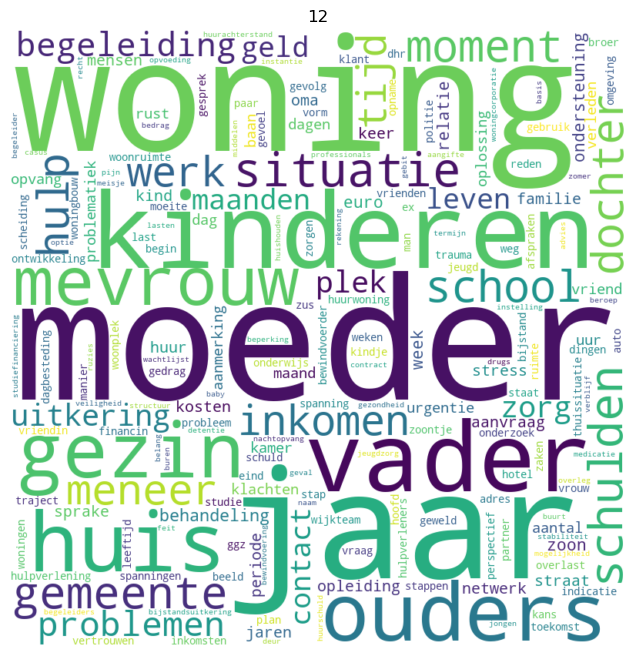

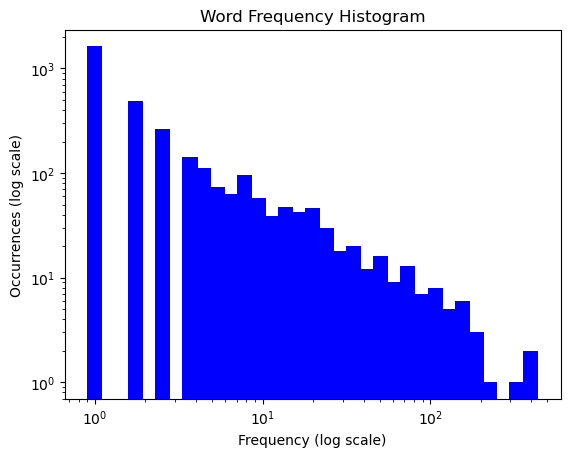

In [14]:
ipw.plots.wordcloud(obs_dict, 12, 8).show()
ipw.plots.histogram_wordfreq(obs_dict).show()

## spaCy vector

In [15]:
import spacy
import nl_core_news_lg

In [16]:
# load natural language model for dutch
nlp = nl_core_news_lg.load()

In [17]:
# Create a list of series objects representing the columns of the new DataFrame  
vector_names = [f"V{i}" for i in range(nlp.vocab.vectors_length)]  
column_list = [] 

for name in vector_names:
     column_list.append(pd.Series(name=name, index=df.index, dtype=float))  
  
# Loop over the strings in the original DataFrame and add their spaCy vectors to the column Series objects  
for i, text in enumerate(df_model_1['text']):  
    doc = nlp(text)  
    for j, value in enumerate(doc.vector):  
        column_list[j][i] = value  
  
# Concatenate the column Series objects to create the new DataFrame  
df_vector_1 = pd.concat(column_list, axis=1)  

## Remove samples that have empty vectors

In [18]:
# Calculate the norm of each row using np.linalg.norm()  
norms = df_vector_1.apply(lambda row: np.linalg.norm(row), axis=1)  

print(f'Number of samples before selection: {len(df)}')
# Filter out the rows where the norm is zero  
df_vector_1 = df_vector_1[norms != 0]  

print(f'Number of samples for clustering: {len(df_vector_1)}')

# also remove from the original dataframe with text
df_model_1 = df_model_1[df_model_1.index.isin(df_vector_1.index)]

Number of samples before selection: 392
Number of samples for clustering: 386


## Correlation

In [19]:
import seaborn as sns

In [20]:
if EDA:
    plt.figure(figsize=(10,10))
    correlation = df_vector_1.corr()
    correlation = np.triu(correlation, k=1)  # Keep only the upper triangle of the correlation matrix  

    sns.heatmap(abs(correlation), center = 0, cmap="RdBu", vmax = 1.0, vmin = 0.0)
    print(f'Max correlation: {correlation.max() :.3f}')  
    print(f'Min correlation: {correlation.min() :.3f}')  
    print(f'Mean absolute correlation: {(abs(correlation)).mean():.3f}')

# Models

## Set Random State

In [21]:
# Set to be able to get repeatable results
RANDOM_STATE = 42

## Distance and affinity matrix

In [22]:
dist_matrix = ipw.models.distance_matrix(df_vector_1)

## Affinity Propagation

In [23]:
model = ipw.enums.Model.AFFINITY_PROPAGATION
dampings = np.arange(0.5, 1.0, 0.05) 
af_results, af_labels, af_centers = ipw.models.affinity_propagation(dist_matrix, dampings, random_state = RANDOM_STATE)
df_model_1[model.col(1)] = af_labels
ipw.models.output(dist_matrix, af_results, af_labels)

Cluster size per cluster
Cluster 0: 44
Cluster 1: 342
----
Best result:
----
Affinity Propagation damping Factor: 0.5
Number of clusters: 2.0
Silhouette Coefficient: 0.238
Calinski-Harabasz Index / Variance Ratio Criterion: 43.771
Davies-Bouldin Index: 1.725


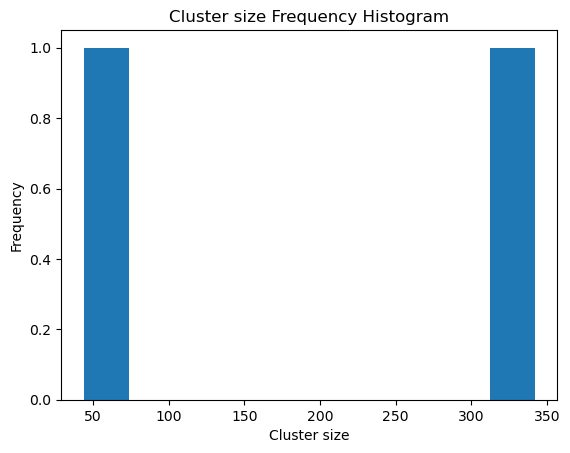

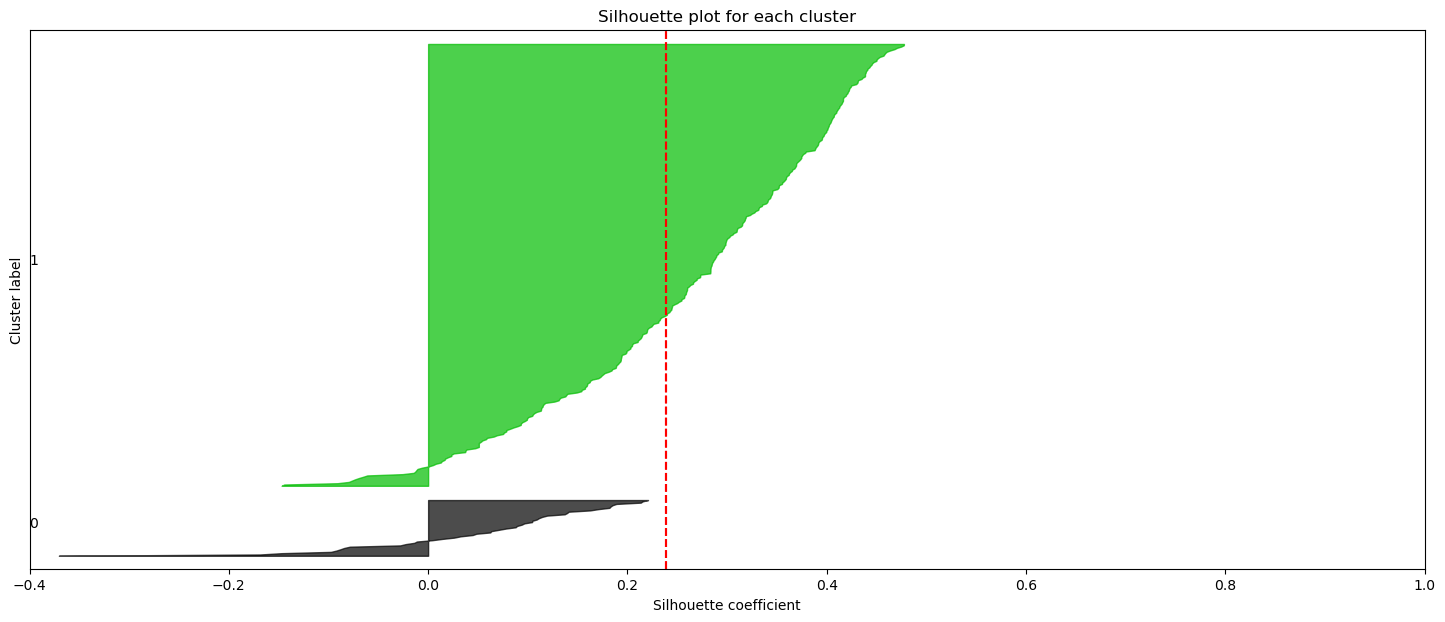

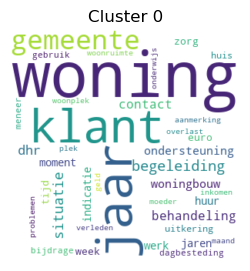

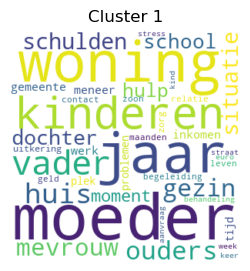

In [24]:
if SHOW_MODEL_PLOTS:
    ipw.plots.histogram_labels(af_labels)
    ipw.plots.silhouette(dist_matrix, af_labels)
    ipw.plots.model_wordclouds(df_model_1, model, 1)

# Agglomerative Clustering

In [25]:
model = ipw.enums.Model.AGGLOMERATIVE_CLUSTERING
n_clusters = range(2, 20)
ac_results, ac_labels = ipw.models.agglomerative_clustering(dist_matrix, n_clusters, RANDOM_STATE)
df_model_1[model.col(1)] = ac_labels
ipw.models.output(dist_matrix, ac_results, ac_labels)

Cluster size per cluster
Cluster 0: 385
Cluster 1: 1
----
Best result:
----
Number of clusters: 2.0
Silhouette Coefficient: 0.665
Calinski-Harabasz Index / Variance Ratio Criterion: 27.034
Davies-Bouldin Index: 0.173


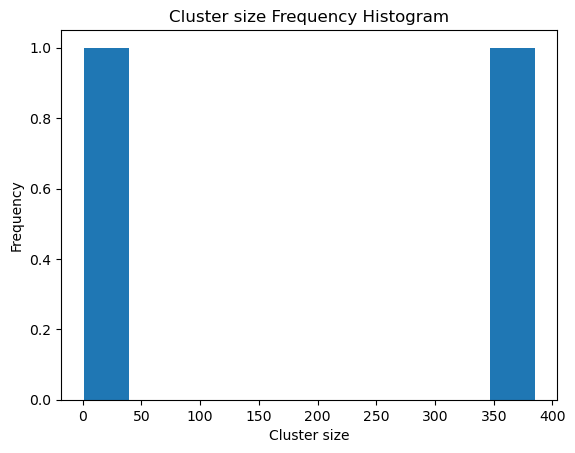

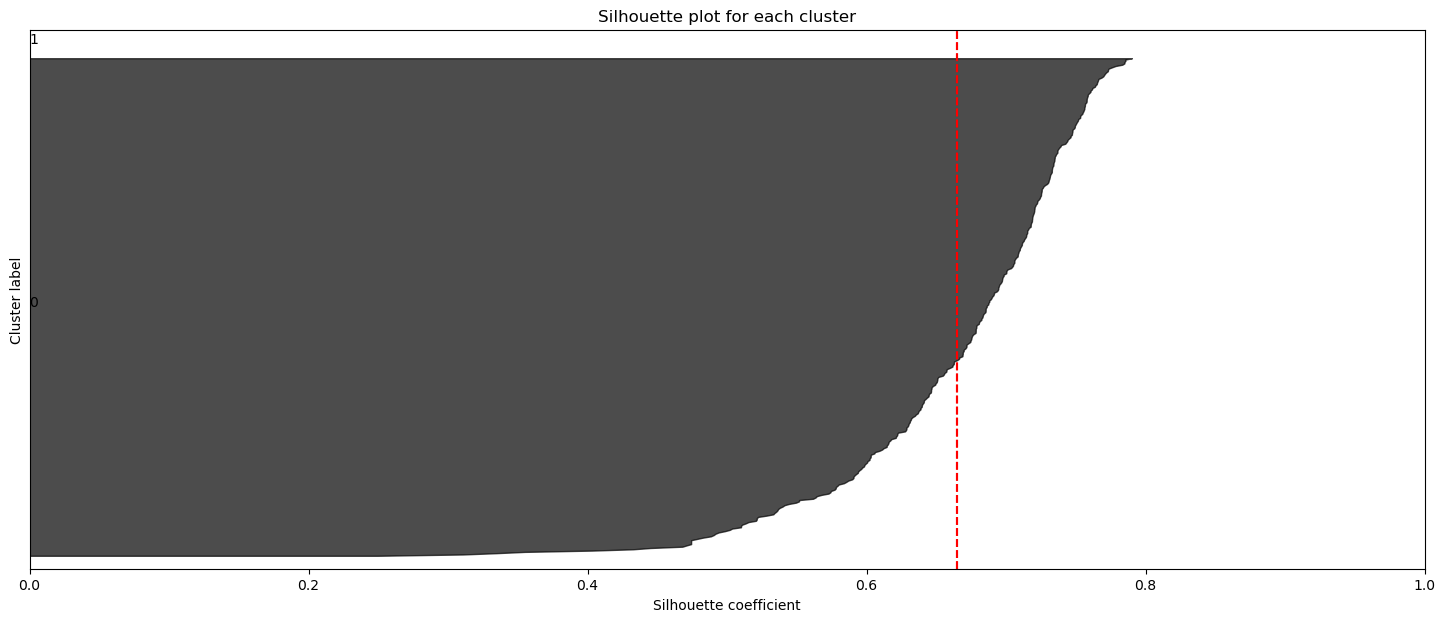

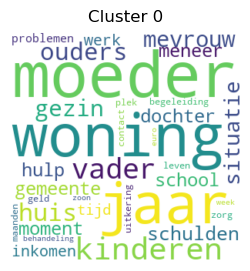

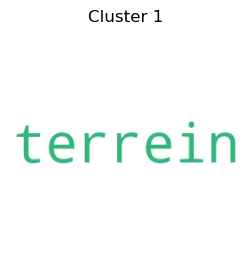

In [26]:
if SHOW_MODEL_PLOTS:
    ipw.plots.histogram_labels(ac_labels)
    ipw.plots.silhouette(dist_matrix, ac_labels)
    ipw.plots.model_wordclouds(df_model_1, model, 1)

# DBScan

In [27]:
model = ipw.enums.Model.DBSCAN
eps_arr = np.arange(0.01, 0.2, 0.01) 
min_samples = range(2, 10)
db_results, db_labels = ipw.models.dbscan(dist_matrix, eps_arr, min_samples)
df_model_1[model.col(1)] = db_labels
ipw.models.output(dist_matrix, db_results, db_labels)

Cluster size per cluster
Cluster -1: 105
Cluster 0: 274
Cluster 1: 7
----
Best result:
----
DBScan epsilon: 0.08
DBScan Weight for core points: 5.0
Number of clusters: 2.0
Silhouette Coefficient: 0.226
Calinski-Harabasz Index / Variance Ratio Criterion: 111.451
Davies-Bouldin Index: 1.199


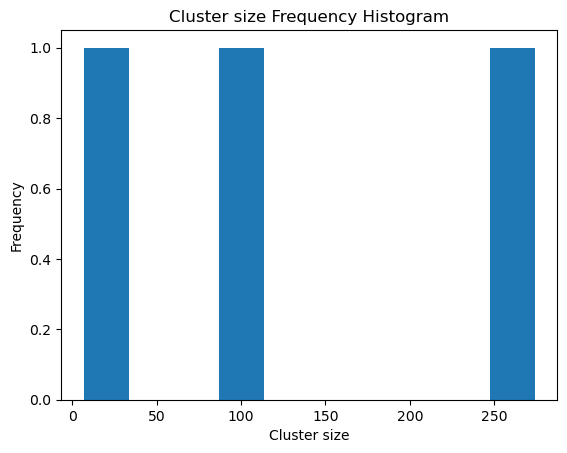

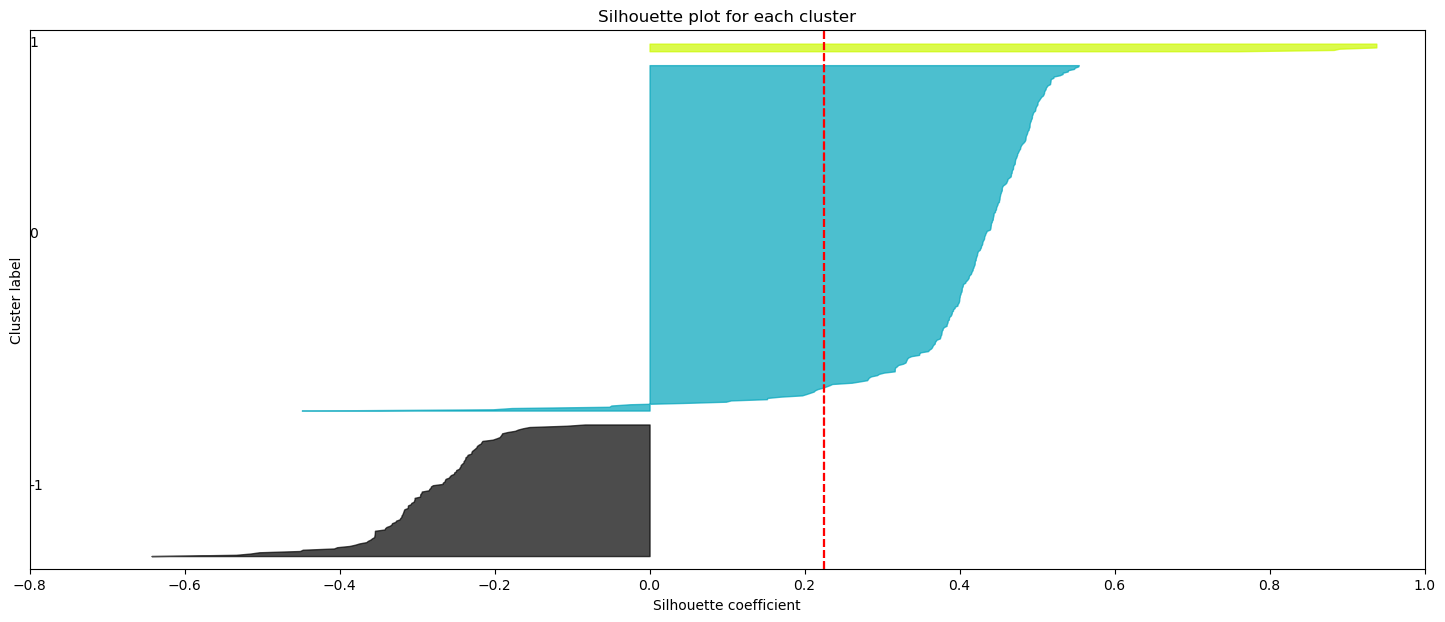

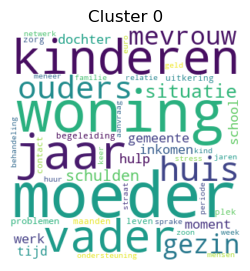

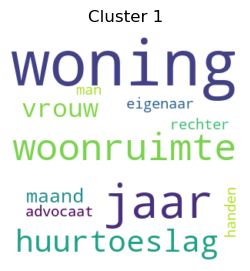

In [28]:
if SHOW_MODEL_PLOTS:
    ipw.plots.histogram_labels(db_labels)
    ipw.plots.silhouette(dist_matrix, db_labels)
    ipw.plots.model_wordclouds(df_model_1, model, 1)

# Spectral Clustering

In [29]:
model = ipw.enums.Model.SPECTRAL_CLUSTERING
n_clusters = range(2, 10)
sc_results, sc_labels = ipw.models.spectral_clustering(dist_matrix, n_clusters, RANDOM_STATE)
df_model_1[model.col(1)] = sc_labels
ipw.models.output(dist_matrix, sc_results, sc_labels)

Cluster size per cluster
Cluster 0: 187
Cluster 1: 199
----
Best result:
----
Number of clusters: 2.0
Silhouette Coefficient: 0.191
Calinski-Harabasz Index / Variance Ratio Criterion: 64.422
Davies-Bouldin Index: 2.124


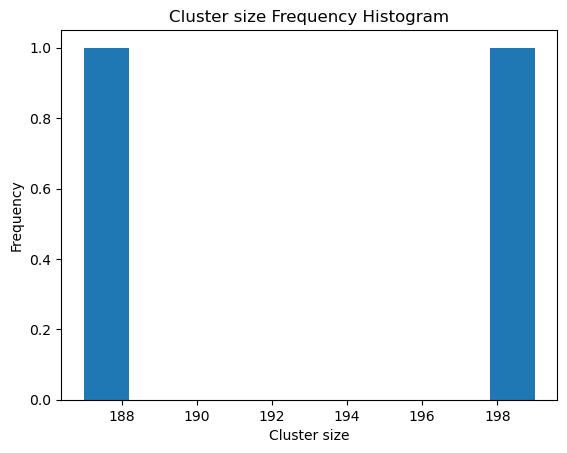

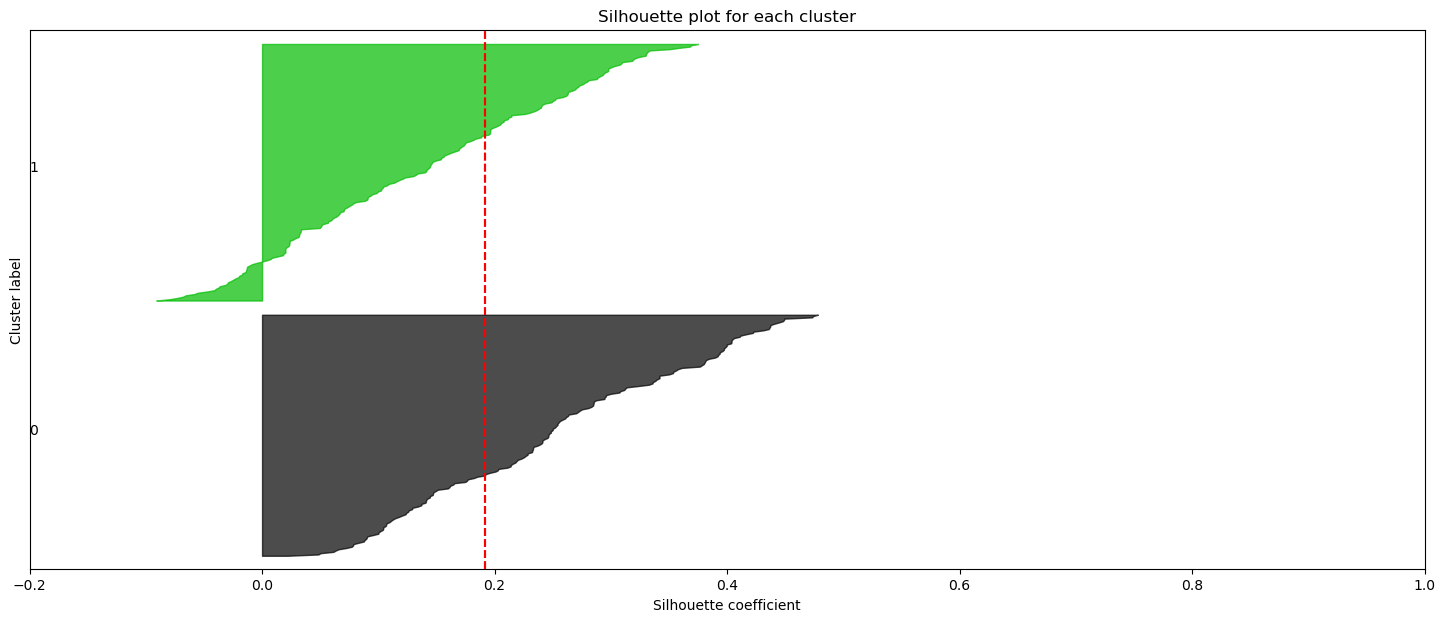

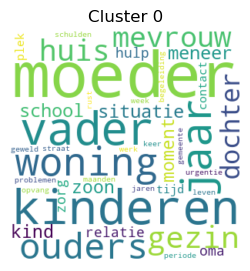

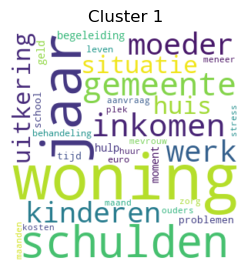

In [30]:
if SHOW_MODEL_PLOTS:
    ipw.plots.histogram_labels(sc_labels)
    ipw.plots.silhouette(dist_matrix, sc_labels)
    ipw.plots.model_wordclouds(df_model_1, model, 1)

In [31]:
descriptions = ipw.text.description_per_label(df_model_1, model, 1)
print(ipw.text.summary(descriptions[0], 5))
print('-----')
print(ipw.text.summary(descriptions[1], 5))

Wesley is 41 jaar en vader van 3 kinderen (dochter van 17 jaar wonend bij haar moeder en 2 zonen van 10 en 4 jaar oud, wonend bij hun moeder) . Hoewel haar moeder haar steunt, is het geen optie dat Nileys met haar kinderen structureel bij haar intrekt, want moeder woont ook particulier en mag haar woning contractueel niet met meer mensen delen, is lichamelijk te zwak en haar woning is bovendien veel te klein voor een stabiel en gezond opvoedklimaat voor de kinderen. Tamara is een alleenstaande moeder van drie kinderen, een zoon van 4 jaar (Riley), een dochter van 12 jaar (Mila) en een zoon van 10 jaar (Dani). Gezin bestaat uit vader, moeder, zus 18 jaar, Aymane 16 jaar en een broertje Ilyas van 5 jaar. Tijdens de laatste van deze ruzies is mevrouw door haar eigen moeder en haar schoonmoeder samen met haar kinderen uit huis gehaald en is zij bij haar moeder gaan verblijven.
-----
Gezondheidsklachten bij de kinderen etc.  - Moeder gaat samen met Aveleijn kijken of ze in aanmerking komt v

# Second Round on column description with Spectral Clustering

In [32]:
from sklearn import metrics

In [33]:
model1 = ipw.enums.Model.SPECTRAL_CLUSTERING
n_clusters = range(2, 10)

In [34]:
df_model_2a = df_model_1[df_model_1[model1.col(1)] == 0].copy()
df_vector_2a = df_vector_1[df_vector_1.index.isin(df_model_2a.index)]
dist_matrix_2a = ipw.distance_matrix(df_vector_2a)

sc_results2a, sc_labels2a = ipw.models.spectral_clustering(dist_matrix_2a, n_clusters, RANDOM_STATE)
df_model_2a[model1.col(2)] = sc_labels2a + 1

In [35]:
df_model_2b = df_model_1[df_model_1[model1.col(1)] == 1].copy()
df_vector_2b = df_vector_1[df_vector_1.index.isin(df_model_2b.index)]
dist_matrix_2b = ipw.distance_matrix(df_vector_2b)

sc_results2b, sc_labels2b = ipw.models.spectral_clustering(dist_matrix_2b, n_clusters, RANDOM_STATE)
df_model_2b[model1.col(2)] = sc_labels2b + 2 + sc_labels2a.max()

In [36]:
merged = pd.concat([df_model_2a, df_model_2b], axis = 0)[[model1.col(2)]]
df_model_2 = df_model_1.join(merged, how = 'left')
df_model_2[df_model_2[model1.col(2)] == None] = 0
labels_2 = df_model_2[model1.col(2)]

n = labels_2.max()
print('Cluster size per cluster')
for i in range(min(labels_2), max(labels_2+1)):
    print(f'Cluster {i}: {sum(labels_2 == i)}')
print('----')
sc = metrics.silhouette_score(dist_matrix, labels_2, metric="precomputed")
vrc = metrics.calinski_harabasz_score(dist_matrix, labels_2)
dbi = metrics.davies_bouldin_score(dist_matrix, labels_2)

print(f'Number of clusters: {labels_2.max() - labels_2.min() + 1}')
print(f'Silhouette Coefficient: {sc:0.3f}')
print(f'Calinski-Harabasz Index / Variance Ratio Criterion: {vrc:0.3f}')
print(f'Davies-Bouldin Index: {dbi:0.3f}')

Cluster size per cluster
Cluster 1: 117
Cluster 2: 70
Cluster 3: 92
Cluster 4: 107
----
Number of clusters: 4
Silhouette Coefficient: 0.092
Calinski-Harabasz Index / Variance Ratio Criterion: 52.153
Davies-Bouldin Index: 2.157


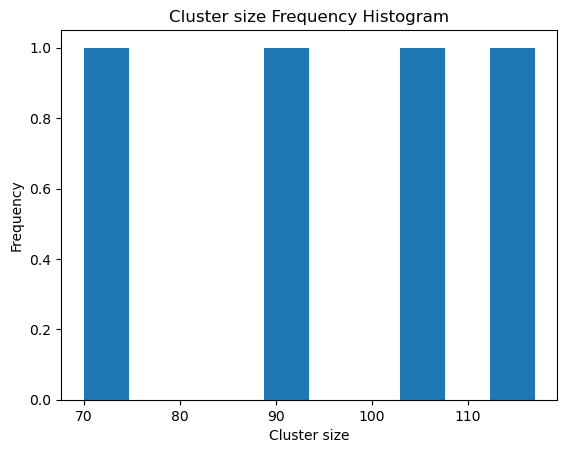

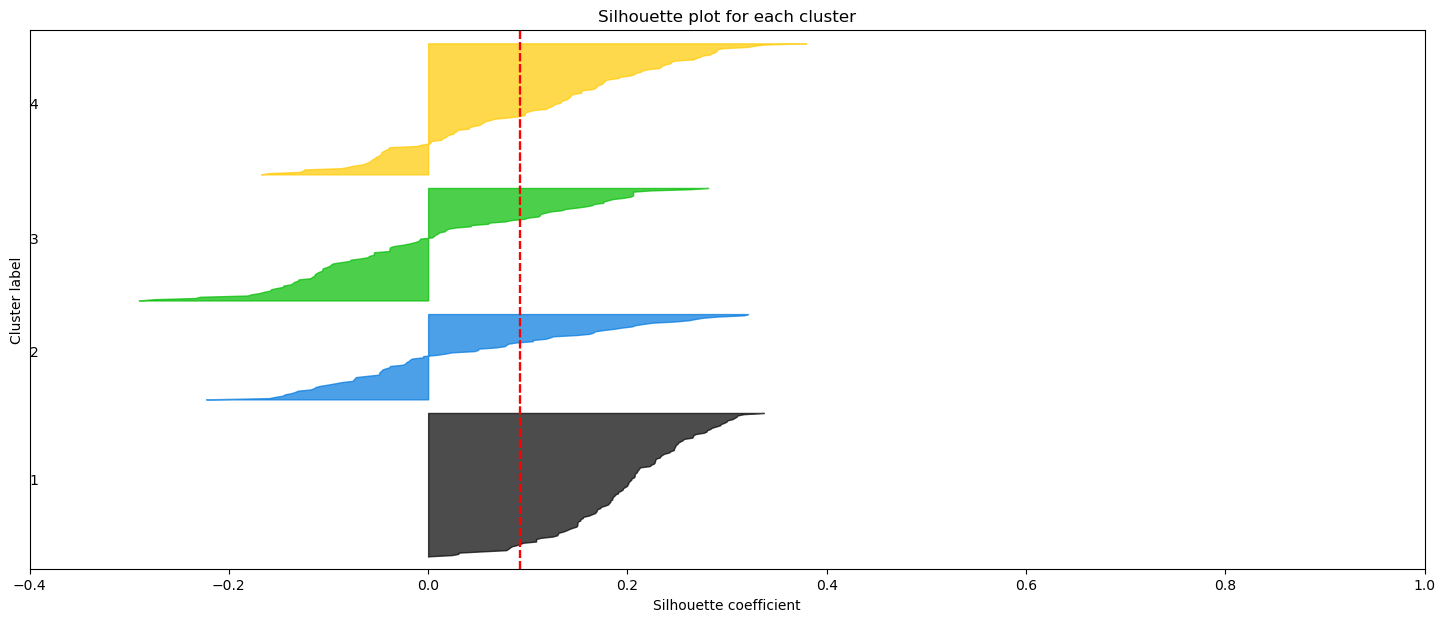

In [37]:
if SHOW_MODEL_PLOTS:
    ipw.plots.histogram_labels(labels_2)
    ipw.plots.silhouette(dist_matrix, labels_2)

# Second Round on column solution with Spectral Clustering

In [117]:
df_model_3 = df['solution'].apply(ipw.text.filter).to_frame('text')
df_model_3['solution'] = df['solution']
df_model_3 = df_model_3[df_model_3.index.isin(df_model_1.index)].copy()

In [118]:
# Create a list of series objects representing the columns of the new DataFrame  
vector_names = [f"V{i}" for i in range(nlp.vocab.vectors_length)]  
column_list = [] 

for name in vector_names:
     column_list.append(pd.Series(name=name, index=df_model_3.index, dtype=float))  
  
# Loop over the strings in the original DataFrame and add their spaCy vectors to the column Series objects  
for i, text in enumerate(df_model_3['text']):  
    doc = nlp(text)  
    for j, value in enumerate(doc.vector):  
        column_list[j][i] = value  
  
# Concatenate the column Series objects to create the new DataFrame  
df_vector_3 = pd.concat(column_list, axis=1)  

In [119]:
# Calculate the norm of each row using np.linalg.norm()  
norms = df_vector_3.apply(lambda row: np.linalg.norm(row), axis=1)  

print(f'Number of samples before selection: {len(df)}')
# Filter out the rows where the norm is zero  
df_vector_3 = df_vector_3[norms != 0]  

print(f'Number of samples for clustering: {len(df_vector_3)}')

# also remove from the original dataframe with text
df_model_3 = df_model_1.copy()

Number of samples before selection: 392
Number of samples for clustering: 372


In [120]:
df_vector_3a = df_vector_3[df_vector_3.index.isin(df_model_2a.index)].copy()
df_model_3a = df_model_3[df_model_3.index.isin(df_vector_3a.index)].copy()
dist_matrix_3a = ipw.distance_matrix(df_vector_3a)

sc_results3a, sc_labels3a = ipw.models.spectral_clustering(dist_matrix_3a, n_clusters, RANDOM_STATE)
df_model_3a[model1.col(3)] = (sc_labels3a + 2)
ipw.models.output(dist_matrix_3a, sc_results3a, sc_labels3a)

Cluster size per cluster
Cluster 0: 100
Cluster 1: 80
----
Best result:
----
Number of clusters: 2.0
Silhouette Coefficient: 0.186
Calinski-Harabasz Index / Variance Ratio Criterion: 30.039
Davies-Bouldin Index: 2.194


In [121]:
df_vector_3b = df_vector_3[df_vector_3.index.isin(df_model_2b.index)].copy()
df_model_3b = df_model_3[df_model_3.index.isin(df_vector_3b.index)].copy()
dist_matrix_3b = ipw.distance_matrix(df_vector_3b)

sc_results3b, sc_labels3b = ipw.models.spectral_clustering(dist_matrix_3b, n_clusters, RANDOM_STATE)
df_model_3b[model1.col(3)] = (sc_labels3a.max() + 3 + sc_labels3b)
ipw.models.output(dist_matrix_3b, sc_results3b, sc_labels3b)

Cluster size per cluster
Cluster 0: 62
Cluster 1: 130
----
Best result:
----
Number of clusters: 2.0
Silhouette Coefficient: 0.213
Calinski-Harabasz Index / Variance Ratio Criterion: 40.679
Davies-Bouldin Index: 1.919


## Output with distance matrix based on description column

In [122]:
merged = pd.concat([df_model_3a, df_model_3b], axis = 0)[[model1.col(3)]]
df_model_3 = df_model_3.join(merged, how = 'left')
df_model_3[model1.col(3)] = df_model_3[model1.col(3)].fillna(df_model_3[model1.col(1)]).astype(int)
labels_3 = df_model_3[model1.col(3)]

In [123]:
labels_3 = df_model_3[model1.col(3)]

In [124]:
n = int(labels_3.max())
print('Cluster size per cluster')
for i in range(n+1):
    print(f'Cluster {i}: {sum(labels_3 == i)}')
print('----')
sc = metrics.silhouette_score(dist_matrix, labels_3, metric="precomputed")
vrc = metrics.calinski_harabasz_score(dist_matrix, labels_3)
dbi = metrics.davies_bouldin_score(dist_matrix, labels_3)

print(f'Number of clusters: {labels_3.max() - labels_3.min() + 1}')
print(f'Silhouette Coefficient: {sc:0.3f}')
print(f'Calinski-Harabasz Index / Variance Ratio Criterion: {vrc:0.3f}')
print(f'Davies-Bouldin Index: {dbi:0.3f}')

Cluster size per cluster
Cluster 0: 7
Cluster 1: 7
Cluster 2: 100
Cluster 3: 80
Cluster 4: 62
Cluster 5: 130
----
Number of clusters: 6
Silhouette Coefficient: -0.039
Calinski-Harabasz Index / Variance Ratio Criterion: 13.699
Davies-Bouldin Index: 9.875


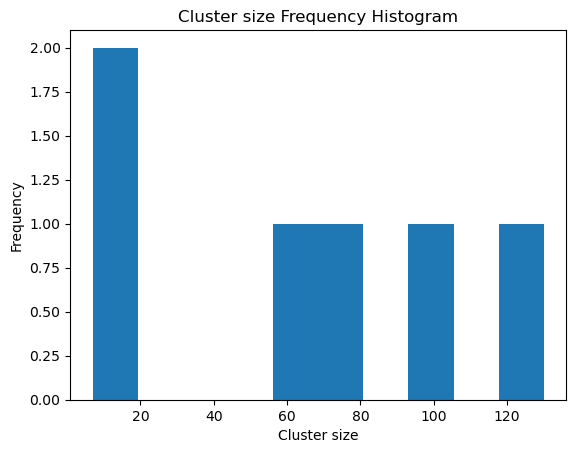

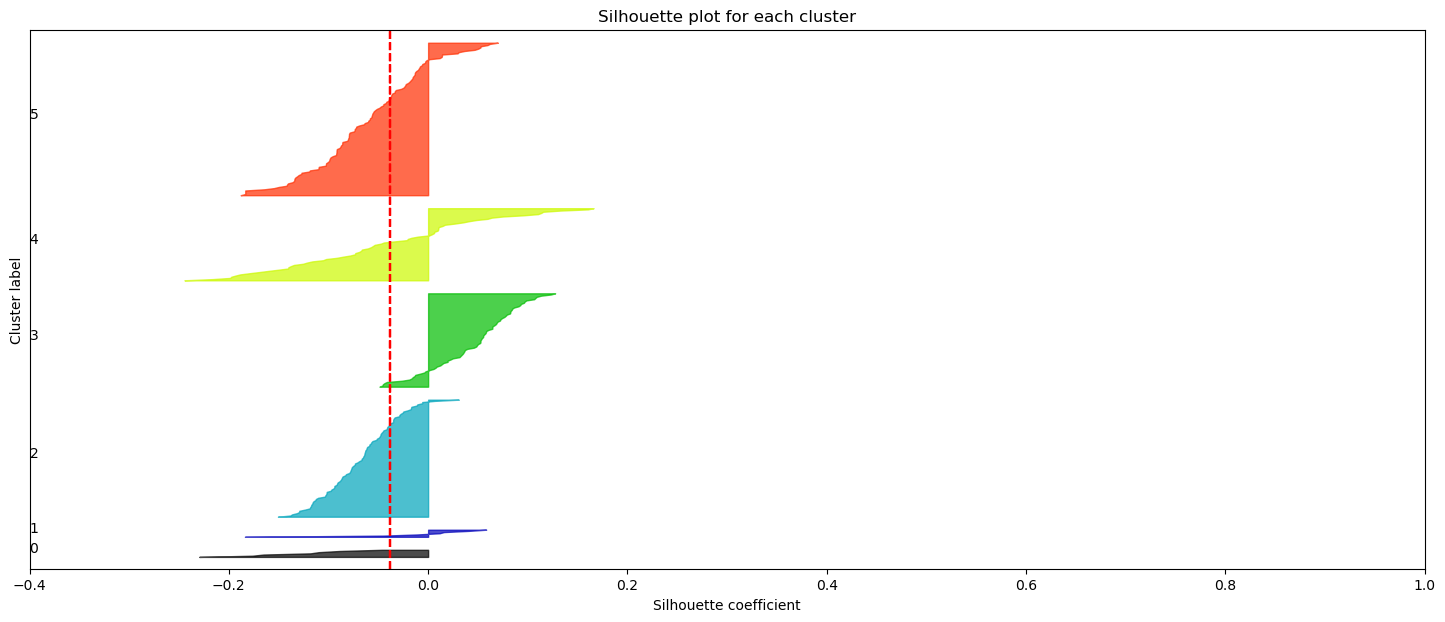

In [125]:
if SHOW_MODEL_PLOTS:
    ipw.plots.histogram_labels(labels_3)
    ipw.plots.silhouette(dist_matrix, labels_3)

## Output with distance matrix based on solution column

In [126]:
df_output = df_model_3[df_model_3.index.isin(df_vector_3.index)].copy()
labels_4 = df_output[model1.col(3)]
distance_sol = ipw.models.distance_matrix(df_vector_3)

In [127]:
n = int(labels_4.max())
print('Cluster size per cluster')
for i in range(n+1):
    print(f'Cluster {i}: {sum(labels_4 == i)}')
print('----')
sc = metrics.silhouette_score(distance_sol, labels_4, metric="precomputed")
vrc = metrics.calinski_harabasz_score(distance_sol, labels_4)
dbi = metrics.davies_bouldin_score(distance_sol, labels_4)

print(f'Number of clusters: {labels_3.max() - labels_3.min() + 1}')
print(f'Silhouette Coefficient: {sc:0.3f}')
print(f'Calinski-Harabasz Index / Variance Ratio Criterion: {vrc:0.3f}')
print(f'Davies-Bouldin Index: {dbi:0.3f}')

Cluster size per cluster
Cluster 0: 0
Cluster 1: 0
Cluster 2: 100
Cluster 3: 80
Cluster 4: 62
Cluster 5: 130
----
Number of clusters: 6
Silhouette Coefficient: 0.021
Calinski-Harabasz Index / Variance Ratio Criterion: 26.101
Davies-Bouldin Index: 6.326


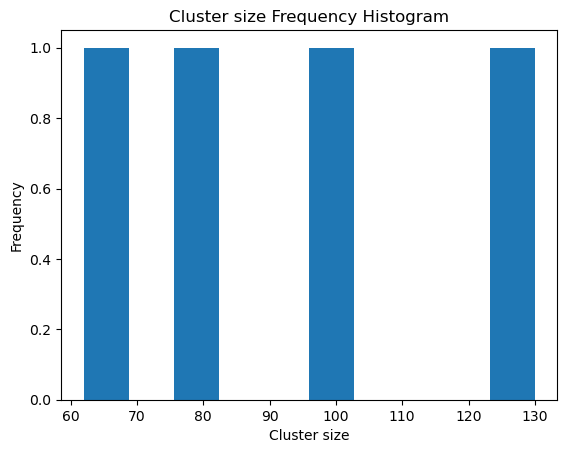

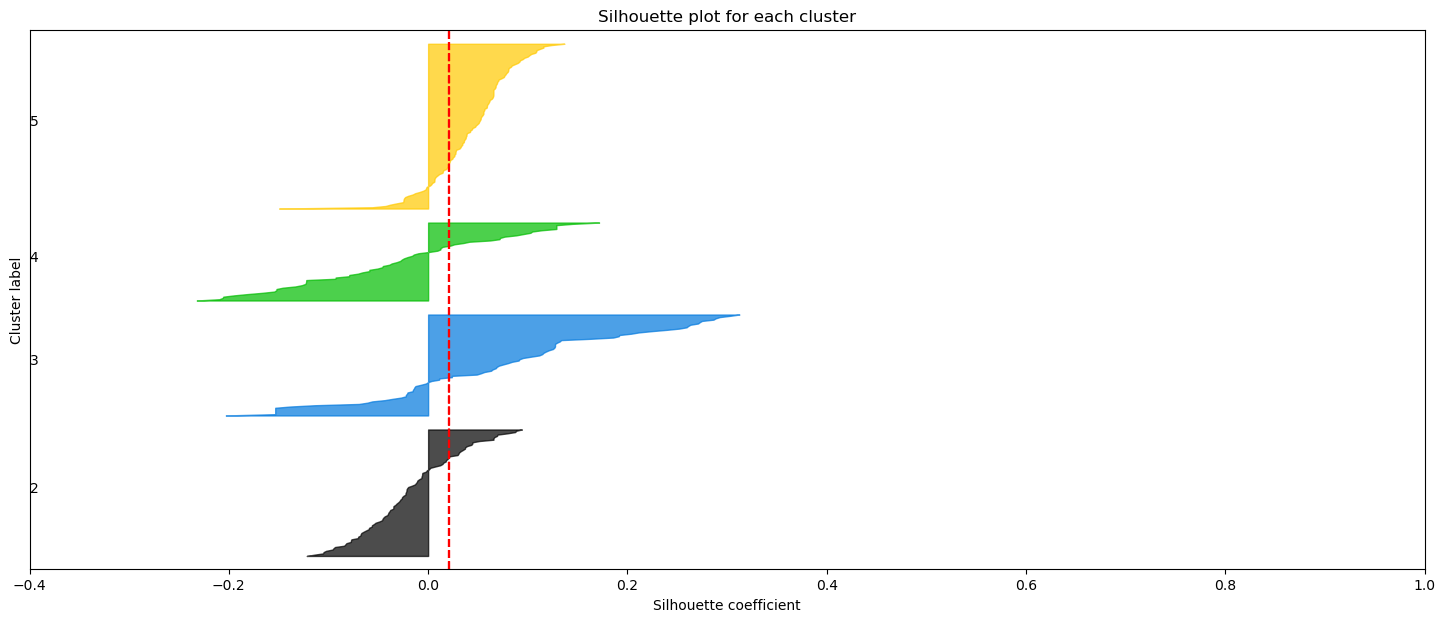

In [129]:
if SHOW_MODEL_PLOTS:
    ipw.plots.histogram_labels(labels_4)
    ipw.plots.silhouette(distance_sol, labels_4)